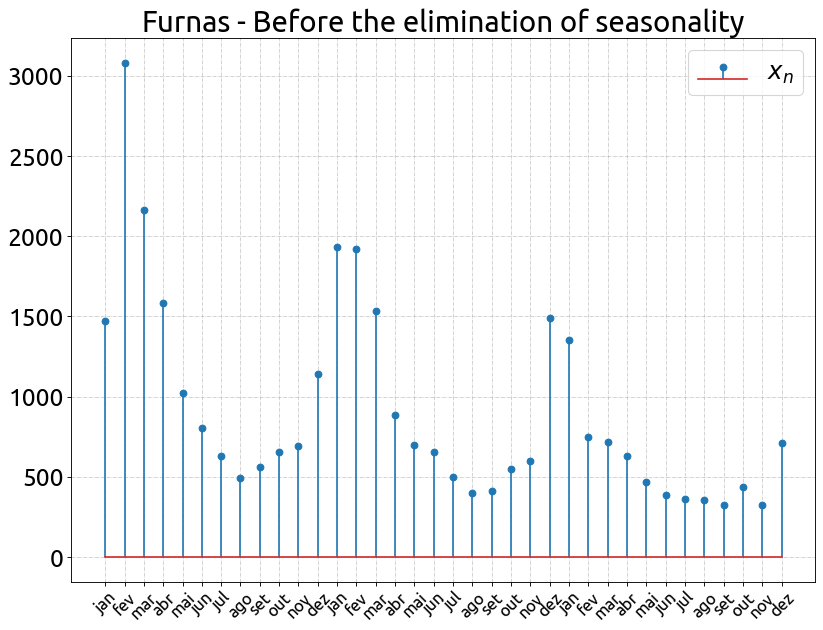

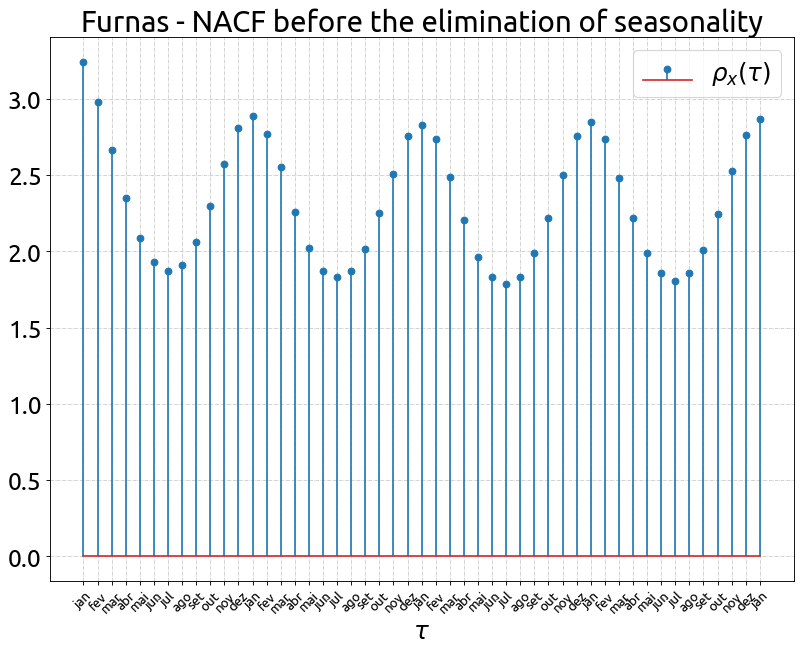

In [1]:
from numpy import genfromtxt, log as ln, sqrt, arange, sum, empty, inner, nan, inf
from numpy.linalg import inv, norm
from scipy.linalg import toeplitz
from my_from_scratch_module import my_normalized_afc
from statsmodels.regression.linear_model import yule_walker
from statistics import mean
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import logging

plt.rcParams.update({'font.family': 'Ubuntu', 'font.weight': 'normal', 'font.size': 22})
furnas = genfromtxt('./data/furnas.dat', dtype=float, delimiter='  ')

def my_var(x):
    N = len(x)
    u_x = sum(x)/N
    return sum((x-u_x)**2)/(N-1)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
# ax.plot(y_hat[:N], 'y--', zorder=2, label='$\hat{y}[k]$')
ax.stem(furnas.flatten('C')[:3*12], label='$x_n$')
ax.legend(loc="upper right")
ax.grid(True, linestyle='-.', linewidth=.5)
ax.set_axisbelow(True)
ax.set_xticks(arange(furnas.flatten('C')[:3*12].size), labels=('jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez')*3, rotation=45, fontsize=15)
plt.title('Furnas - Before the elimination of seasonality')
plt.show()

# normalized autocorrelation function
nafc_furnas = my_normalized_afc(furnas.flatten('C'), 12*4)

fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
# ax.plot(y_hat[:N], 'y--', zorder=2, label='$\hat{y}[k]$')
ax.stem(nafc_furnas, label=r'$\rho_x(\tau)$')
ax.legend(loc="upper right")
ax.set_xticks(arange(nafc_furnas.size), labels=('jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez')*(nafc_furnas.size//12) + ('jan',), rotation=45, fontsize=12)
plt.title('Furnas - NACF before the elimination of seasonality')
plt.xlabel(r'$\tau$')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

# What is it possible to infer from these graphs?

Let us define $x_{n}$ as a stochastic process which the temporal support represents the samples collected monthly of the water flux of Furnas.One of the primaries tasks of characterization of a time-series random process is to define whether $x_{n}$ is a stationarity.

In the strict sense, stationarity is defined as the time invariance of the joint statistics of a process. The temporal independence comes from the invariance of shifting of $\tau$ in the probability density function (PDF) of $x_{n}$. The bigger is the joint PDF that is statement holds, the bigger is the stationarity order of $x_{n}$.

If $x_{n}$ is $k$-order stationary random process (RP), then

\begin{align}
    p (x_{n_1}, x_{n_2}, \dots, x_{n_k}) = p (x_{n_1+\tau}, x_{n_2+\tau}, \dots, x_{n_k+\tau})
\end{align}
is true for all $\tau\in\mathbb{N}$, where $p (x_n)$ the PDF of $x_n$. In practice, it is harsh to verify whether a RP is stationary in the strict sense. Therefore, a usual way out is to limit the supposition to a $2$-order stationary process, and we call $x_{n}$ wide-sense stationarity (WSS). This guarantee that the statistics of first (mean and variance) and second (autocorrelation and autocovariance functions) order are time invariant. It mean that

\begin{align}
    m_x\left( n_0 \right) = m_x\left( n_1 \right) = m_x, & \: \forall \; n_0, n_1 \in \mathbb{R}.
\end{align}

Suppose that we have a new independent realization of $x_n$ at each year. This means that, from the dataset, we have $N=60$ independent realizations of this stochastic process. Let us define
\begin{align}
	\mathbf{x} = \begin{bmatrix}
    x_{n_1} & x_{n_2} & \dots & x_{n_{12}} \end{bmatrix}^\mathsf{T}
\end{align}

as a random vector (RV), where $x_{n_1}$ to $x_{n_{12}}$ indicate the samples from January to December, respectively. It is possible the compute the sample mean of this RV as,

\begin{align}
    \hat{\mathbf{m}}_\mathbf{x} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{x}_i,
\end{align}

where
\begin{align}
	\mathbf{x}_i = \begin{bmatrix}
    x_{n_{1,i}} & x_{n_{2,i}} & \dots & x_{n_{12,i}} \end{bmatrix}^\mathsf{T},
\end{align}

where $\mathbf{x}_i$ and $x_{n_{1,i}}$ is the $i$-th realization of $\mathbf{x}$ and $x_{n_{1}}$, respectively, and
\begin{align}
	\hat{\mathbf{m}}_\mathbf{x} = \begin{bmatrix}
    m_x(n_1) & m_x(n_2) & \dots & m_x(n_{12}) \end{bmatrix}^\mathsf{T}.
\end{align}
The result is

In [2]:
X = furnas.T

# mean vector estimation
mu_x = sum(X, axis=1)/X.shape[0]
print(mu_x)

[8596.33333333 8345.83333333 7590.         5098.08333333 3717.33333333
 3115.08333333 2577.5        2156.         2237.25       2661.91666667
 3738.75       6341.16666667]


Clearly, the mean value, $m_x(n_i)$, is not the same for all $n_i$, $1\leq i \leq 12$. So, **we conclude that $x(n)$ is not a WSS random process**.

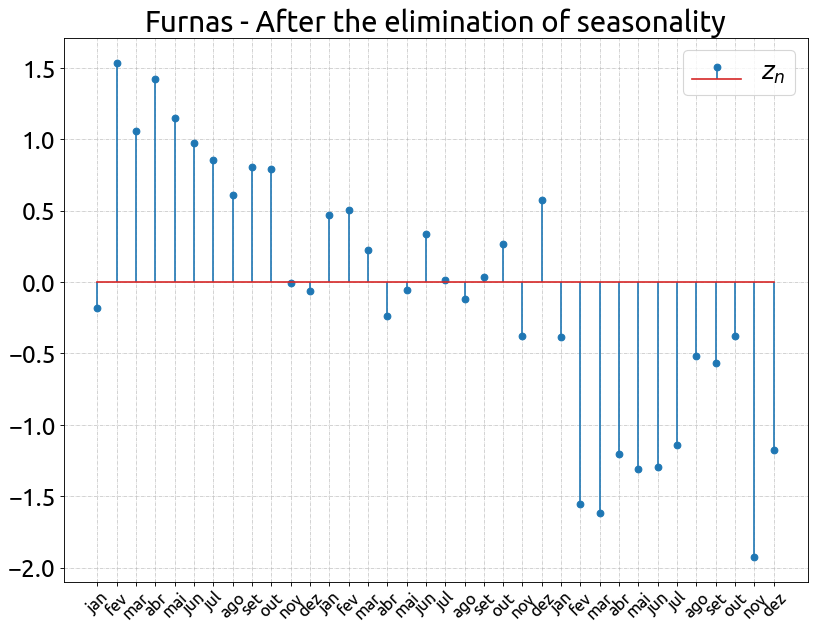

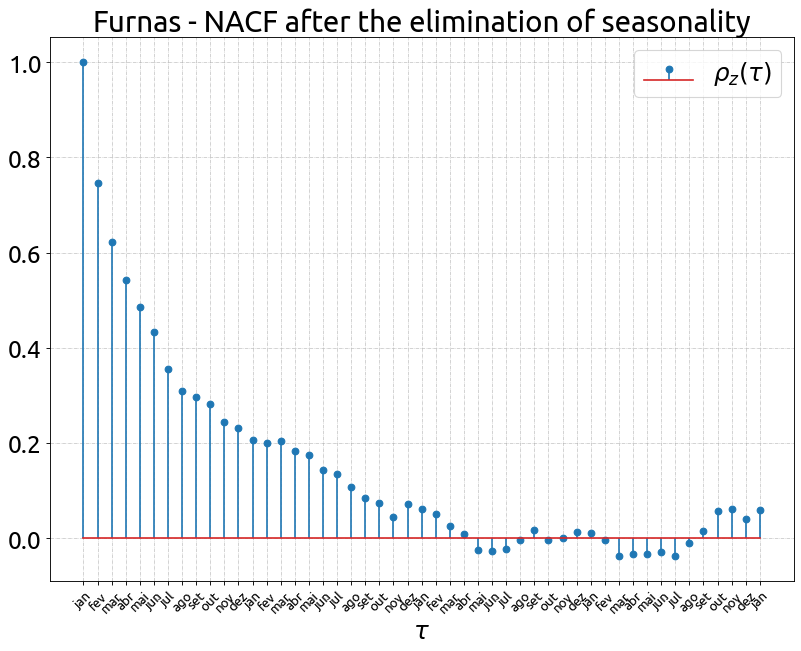

In [10]:
# Y -> [number of realizations (ensemble) x number of RV'S]
Y = ln(furnas)
# mean vector estimation
mu_y = sum(Y, axis=0)/Y.shape[0]
# variance vector estimation (unbiased)
sigma2 = sum((Y - mu_y)**2, axis=0)/(Y.shape[0]-1)
# transformed time series
Z = (Y - mu_y)/sqrt(sigma2)
# vectorize Z
z = Z.flatten('C')

# plot time-series z(n)
fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
ax.stem(z[:3*12], label='$z_n$')
ax.legend(loc="upper right")
ax.set_xticks(arange(z[:3*12].size), labels=('jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez')*3, rotation=45, fontsize=15)
plt.title('Furnas - After the elimination of seasonality')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

# plot normalized autocorrelation function
nafc_z = my_normalized_afc(z, 12*4)
fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
ax.stem(nafc_z, label=r'$\rho_z(\tau)$')
ax.legend(loc="upper right")
ax.set_xticks(arange(nafc_z.size), labels=('jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez')*(nafc_z.size//12) + ('jan',), rotation=45, fontsize=12)
plt.title('Furnas - NACF after the elimination of seasonality')
plt.xlabel(r'$\tau$')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

# Partial Autocorrelation Function (PACF)

/home/tapyu/.cache/pypoetry/virtualenvs/id-sist-sFYUFp5A-py3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


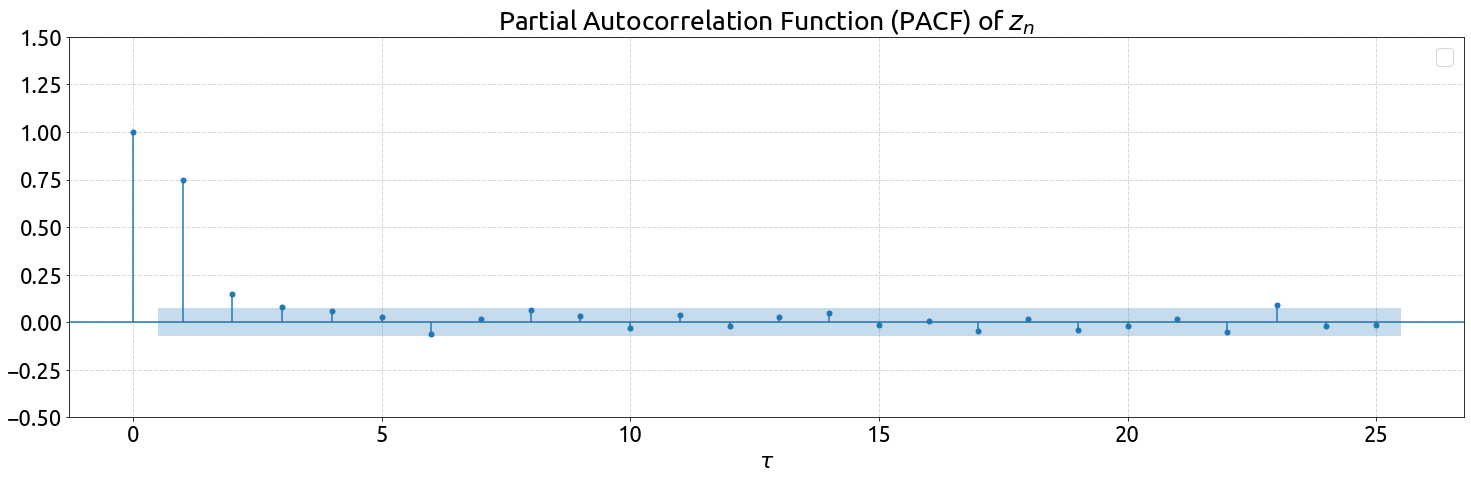

In [4]:
fig = plot_pacf(z, lags=25)
fig.set_size_inches((25,7))
ax = fig.gca()
ax.legend(loc="upper right")
ax.grid(True, linestyle='-.', linewidth=.5)
ax.set_axisbelow(True)
ax.set_ylim((-.5, 1.5))
ax.set_xlabel(r'$\tau$')
ax.set_title('Partial Autocorrelation Function (PACF) of $z_n$')
plt.show()

The PACF provides a benchmark for the correlation of two instances delayed by $\tau$. Since it does not take into account any sample between $z_{n-1}$ and $z_{n-\tau+1}$, we have a sole measurement of how much the sample $z_{n-\tau}$ is correlated with the sample $z_{n}$ (that is why it is called partial ACF). The higher is the PACF for a delay $\tau$, the more correlated both are, which indicates that $n-\tau$-th sample should be used in the model. Naturally, the PACF is often used in time series modelling when it is interested in finding out what order of AR(p) model to use.

From this graph, **we see that $p=1$ is a sensible choice for the AR(p) model**.

# Determination of the AR(p) via AIC, BIC, FPE, and MDL

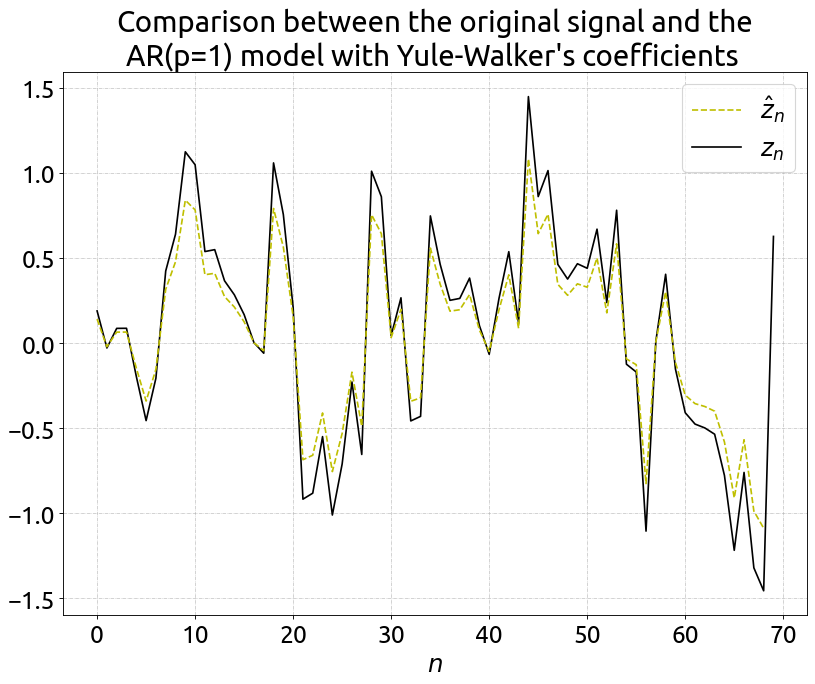

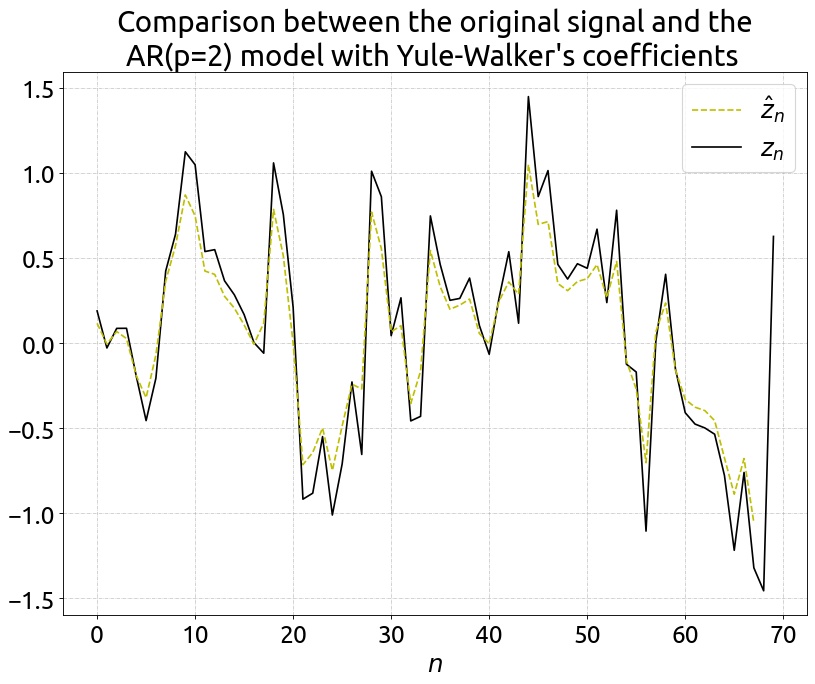

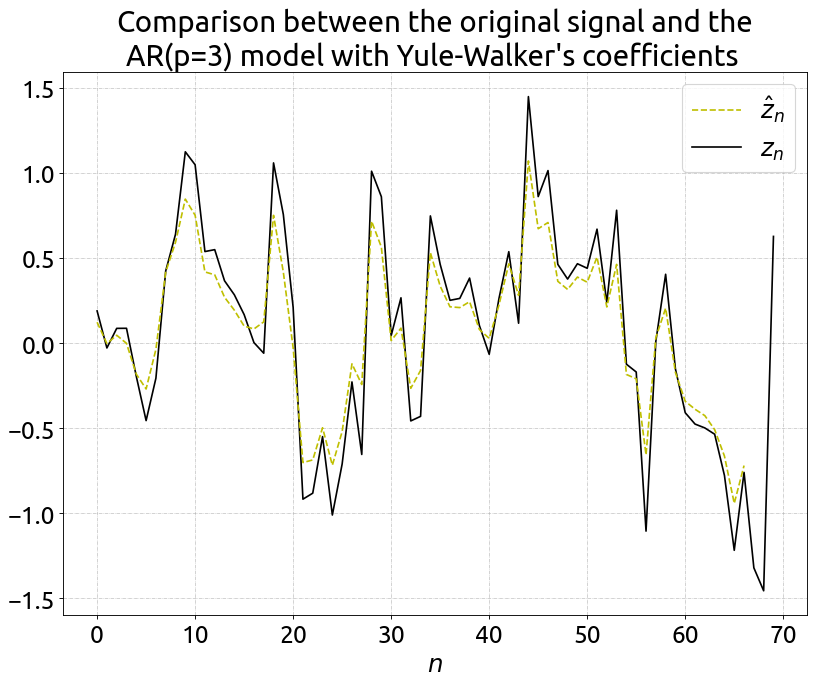

In [5]:
AIC, BIC, FPE, MDL = empty(3), empty(3), empty(3), empty(3)
AIC_best, BIC_best, FPE_best, MDL_best = inf, inf, inf, inf
all_p = range(1,4)

# for p in range(3):
for i, p in enumerate(all_p):
    # length of the random process
    N = z.size
    # compute the autocorrelation function (normalized version), r_k -> r[k] -> [r[0], r[1], ..., r[p]]
    r_k = empty(p+1)
    for k in range(p+1):
        r_k[k] = inner(z[:N-k], z[k:N])/(N-k)
    r_k /= my_var(z)
    # correlation matrix
    # r_k[:p] -> [r[0], r[1], ..., r[p-1]]
    R = toeplitz(r_k[:p])
    # correlation vector
    # r -> [r[1], r[2], ..., r[p]]
    r = r_k[1:]
    # Yule-Walker equation
    a = inv(R) @ r
    # built-in function for comparison purpose
    a_hat, _ = yule_walker(z, order=p)

    z_hat = empty(N)
    z_hat[:] = nan
    for n in range(p,N):
        z_hat[n] = inner(a, z[n-p:n][::1])

    fig = plt.figure(figsize=(12, 9), dpi=80)
    ax = fig.gca()
    ax.set_axisbelow(True)
    ax.plot(z_hat[100+p:170], 'y--', zorder=2, label='$\hat{z}_n$')
    ax.plot(z[100:170], 'k', zorder=1, label='$z_n$')
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='-.', linewidth=.5)
    plt.xlabel(r'$n$')
    plt.title(f'Comparison between the original signal and the\nAR(p={p}) model with Yule-Walker\'s coefficients ')
    plt.show()

    xi = z[:-p] - z_hat[p:]
    N_xi = xi.size
    sigma2_xi = my_var(xi)
    # Akaike’s Information criterion (AIC)
    AIC[i] = N_xi*ln(sigma2_xi) + 2*p
    # Bayesian Information criterion (BIC)
    BIC[i] = N_xi*ln(sigma2_xi) + p*ln(N_xi)
    # final prediction error (FPE)
    FPE[i] = N_xi*ln(sigma2_xi) + N_xi*ln((N_xi+p)/(N_xi-p))
    # minimum description length (MDL)
    MDL[i] = N_xi*ln(sigma2_xi) + .5*p*ln(N_xi)

    if AIC[i] < AIC_best:
        AIC_best = AIC[i]
        AIC_besti = i
        xi_best = xi
        a_best = a
        a_hat_best = a_hat
    if BIC[i] < BIC_best:
        BIC_best = BIC[i]
        BIC_besti = i
    if FPE[i] < FPE_best:
        FPE_best = FPE[i]
        FPE_besti = i
    if MDL[i] < MDL_best:
        MDL_best = MDL[i]
        MDL_besti = i

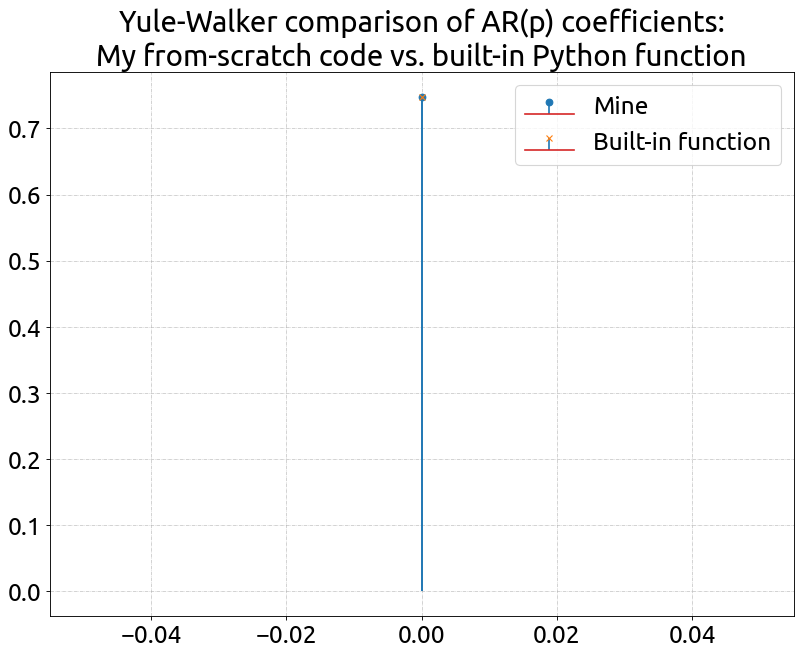

In [6]:
fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
# get just an example
ax.stem(a_best, markerfmt='o-', label='Mine')
ax.stem(a_hat_best, markerfmt='x-', label='Built-in function')
plt.legend(loc="upper right")
plt.title('Yule-Walker comparison of AR(p) coefficients:\nMy from-scratch code vs. built-in Python function')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

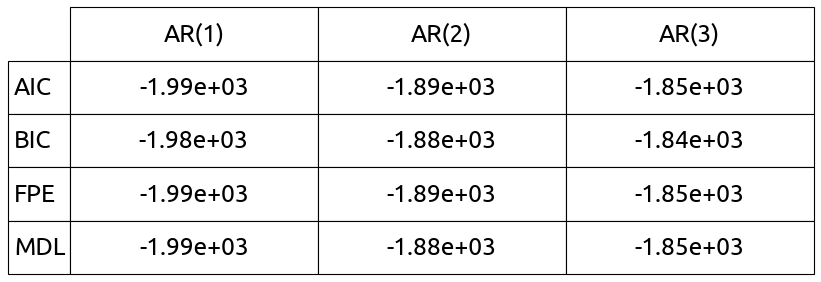




	The best option for the AIC is {p}={1, 1}
	The best option for the BIC is {p}={1, 1}
	The best option for the FPE is {p}={1, 1}
	The best option for the MDL is {p}={1, 1}


In [7]:
fig = plt.figure(figsize=(12, 3), dpi=80)
ax = fig.gca()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
col_labels = [f'AR({p})' for p in all_p]
row_labels = ['AIC', 'BIC', 'FPE', 'MDL']
cell_tex = [[f'{i:.2e}' for i in x] for x in (AIC, BIC, FPE, MDL)]

table_ = ax.table(cellText=cell_tex, colLabels=col_labels, loc='center', cellLoc='center', rowLabels=row_labels)
table_.scale(1, 4)
plt.show()

print('\n\n')
for criteria, besti in zip(('AIC', 'BIC', 'FPE', 'MDL'), (AIC_besti, BIC_besti, FPE_besti, MDL_besti)):
    print(f'\tThe best option for the {criteria} is {{p}}={{{all_p[besti]}, {all_p[besti]}}}')

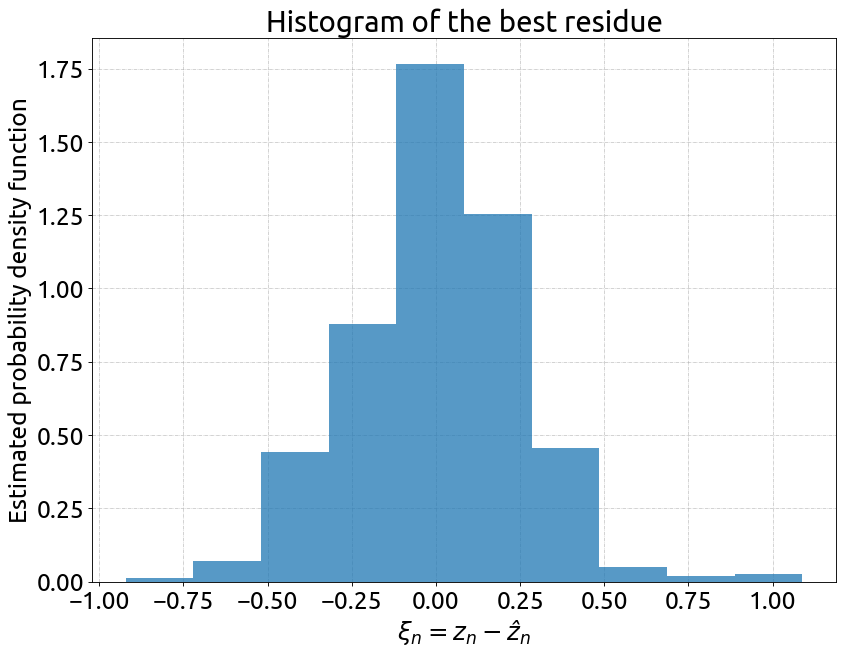

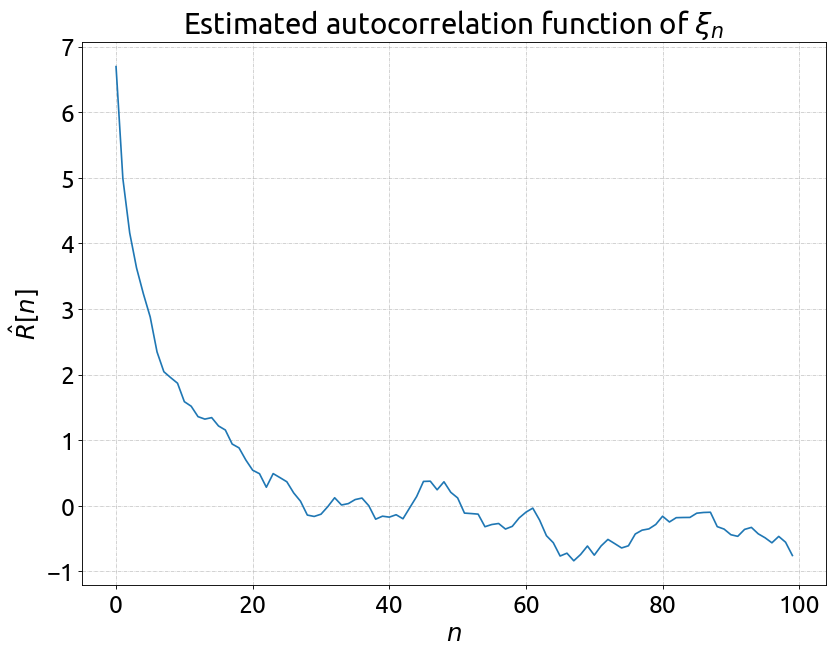

The root mean square error to the best AR(p) residue is:2.50e-01


In [8]:
### histogram of the best residue
fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
ax.hist(xi_best, bins=10, density=True, alpha=0.75)
plt.xlabel(r'$\xi_n = z_n-ẑ_n$')
plt.ylabel('Estimated probability density function')
plt.title('Histogram of the best residue')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

### autocorrelation function
n_max = 100
# truncate the empty part
xi_best = xi_best[p:]
N_e = xi_best.size
r = empty(n_max)
for n in range(n_max):
    r[n] = inner(xi_best[:N_e-n], xi_best[n:])/norm(xi_best)

fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
ax.plot(r)
plt.xlabel(r'$n$')
plt.ylabel(r'$\hat{R}\left[n\right]$')
plt.title(r'Estimated autocorrelation function of $\xi_n$')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

rmse_e = sqrt(mean(xi_best**2))
print(f'The root mean square error to the best AR(p) residue is:{rmse_e:.2e}')